In [1]:
from os import remove
import random
from pathlib import Path
from PIL import Image
import pickle
import augly.image as imaugs
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from oemer.bbox import get_bbox, merge_nearby_bbox, draw_bounding_boxes, rm_merge_overlap_bbox
from oemer.build_label import find_example

In [2]:
TARGET_WIDTH = 40
TARGET_HEIGHT = 70
DISTANCE = 10

DATASET_PATH = "./ds2_dense/segmentation"

In [3]:
def _collect(color, out_path, samples=400):
    out_path = Path(out_path)
    if not out_path.exists():
        out_path.mkdir()

    cur_samples = 0
    add_space = 10
    idx = 0
    while cur_samples < samples:
        arr = find_example(DATASET_PATH, color)
        if arr is None:
            continue
        arr[arr!=200] = 0
        boxes = get_bbox(arr)
        if len(boxes) > 1:
            boxes = merge_nearby_bbox(boxes, DISTANCE)
        boxes = rm_merge_overlap_bbox(boxes)
        for box in boxes:
            if idx >= samples:
                break
            print(f"{idx+1}/{samples}", end='\r')
            patch = arr[box[1]-add_space:box[3]+add_space, box[0]-add_space:box[2]+add_space]
            ratio = random.choice(np.arange(0.6, 1.3, 0.1))
            tar_w = int(ratio * patch.shape[1])
            tar_h = int(ratio * patch.shape[0])
            img = imaugs.resize(Image.fromarray(patch.astype(np.uint8)), width=tar_w, height=tar_h)

            seed = random.randint(0, 1000)
            img = imaugs.perspective_transform(img, seed=seed, sigma=3)
            img = np.where(np.array(img)>0, 255, 0)
            Image.fromarray(patch.astype(np.uint8)).save(out_path / f"{idx}.png")
            idx += 1

        cur_samples += len(boxes)
    print()

In [4]:
def collect_data(samples=400):
    color_map = {
#         74: "sharp",
#         70: "flat",
#         72: "natural",
        97: 'rest_whole',
        98: 'rest_half',
        99: 'rest_quarter',
        100: 'rest_8th',
#         101: 'rest_16th',
#         102: 'rest_32nd',
#         103: 'rest_64th',
#         104: 'rest_128th'
        # 10: 'gclef',
        # 13: 'fclef',
        # 추가: time signature에 해당하는 데이터
#         21: 'timesig_0',
#         22: 'timesig_1',
#         23: 'timesig_2',
#         24: 'timesig_3',
#         25: 'timesig_4',
#         26: 'timesig_5',
#         27: 'timesig_6',
#         28: 'timesig_7',
#         29: 'timesig_8',
#         30: 'timesig_9',
#         33: 'timesig_4_4',
#         34: 'timesig_2_2',
    }
    
    for color, name in color_map.items():
        print('Current', name)
        _collect(color, f"./ds2_dense/train_data/{name}", samples=samples)
        _collect(color, f"./ds2_dense/test_data/{name}", samples=samples)

In [5]:
def train(folders):
    class_map = {idx: Path(ff).name for idx, ff in enumerate(folders)}
    train_x = []
    train_y = []
    samples = None
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        idx = 0
        for ff in folder.glob('*.png'):
            if samples is not None and idx >= samples:
                break
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img).flatten()
            train_x.append(arr)
            train_y.append(cidx)
            idx += 1
    print("Train model")
    model = svm.SVC()
    model.fit(train_x, train_y)

    return model, class_map

In [6]:
def test(model, folders):
    test_x = []
    test_y = []
    samples = 400
    print("Loading data")
    for cidx, folder in enumerate(folders):
        folder = Path(folder)
        idx = 0
        files = list(folder.glob('*.png'))
        random.shuffle(files)
        for ff in tqdm(files[:samples], desc=f"Folder {cidx+1}/{len(folders)}", ncols=800):  # Add tqdm for progress bar
            img = Image.open(ff).resize((TARGET_WIDTH, TARGET_HEIGHT))
            arr = np.array(img).flatten()
            test_x.append(arr)
            test_y.append(cidx)
            idx += 1

    pred_y = model.predict(test_x)
    tp_idx = (pred_y == test_y)
    tp = len(pred_y[tp_idx])
    acc = tp / len(test_y)
    print("Accuracy: ", acc)


    # 클래스 별 정확도 계산
    class_accuracy = {}
    for cidx, folder in enumerate(folders):
        idx = np.where(np.array(test_y) == cidx)
        class_accuracy[folder] = accuracy_score(np.array(test_y)[idx], np.array(pred_y)[idx])

    # 파일 경로에서 폴더 이름만 추출하여 X 축에 표시
    class_names = [folder.split("/")[-1] for folder in class_accuracy.keys()]

    plt.figure(figsize=(8, 6))

    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

    # 그래프 생성
    bars = plt.bar(class_names, class_accuracy.values(), color=colors)

    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Class-wise Accuracy', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [7]:
def predict(region, model_name):
    if np.max(region) == 1:
        region *= 255
    m_info = pickle.load(open(f"sklearn_models/{model_name}.model", "rb"))
    model = m_info['model']
    w = m_info['w']
    h = m_info['h']
    region = Image.fromarray(region.astype(np.uint8)).resize((w, h))
    pred = model.predict(np.array(region).reshape(1, -1))
    return m_info['class_map'][pred[0]]

In [8]:
samples = 400

collect_data(samples=samples)

folders = ["rest_whole", "rest_half", "rest_quarter", "rest_8th"]
model_name = "rests"

Current rest_whole
400/400
400/400
Current rest_half
400/400
400/400
Current rest_quarter
400/400
400/400
Current rest_8th
400/400
400/400


In [9]:
model, class_map = train([f"ds2_dense/train_data/{folder}" for folder in folders])

Loading data
Train model


Loading data


Folder 4/4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 435.18it/s]


Accuracy:  0.790625


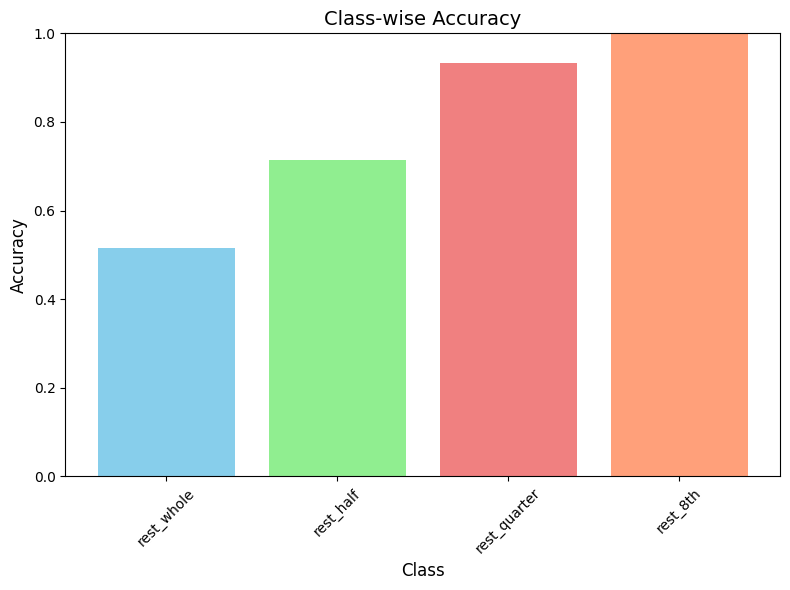

In [10]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

test(model, [f"ds2_dense/test_data/{folder}" for folder in folders])

In [11]:
output = {'model': model, 'w': TARGET_WIDTH, 'h': TARGET_HEIGHT, 'class_map': class_map}
pickle.dump(output, open(f"sklearn_models/{model_name}.model", "wb"))